<a href="https://colab.research.google.com/github/code-front/BluesBot/blob/master/DeepLearningModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Datasetting**
**Preprocessing**
**Train & Validate**
**Test**

In [0]:
import glob
import pickle
import numpy as np
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from music21 import converter, instrument, note, chord, midi, stream
from music21 import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# **Mount Google Drive**

---
We run a cell that will allow us to use our **Google Drive** accounts to store files that can be used inside the python notebook (.ipynb). Upon execution, this cell will prompt the user to enter a URL where an authorization code can be copied and pasted into the notebook for access.


In [0]:
from google.colab import drive
# prompt drive authorization
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Import Dataset

---
The dataset contains thirty midi files. The type of files that I chose to work with are a mix of Jazz songs that I found realxing and popular Anime shows. 

After downloading each file individually, I opened them into FL Studio, a professional music tool, so that I could process them. Some files consisted only of a piano instrument while others contained a wide variety of instruments. The data cleansing routine that I followed: Remove any empty spacing at the beginning of the file so that the model didn't train on too many resting measures, filtered out any instrument that wasn't a piano like removing any striking percussion instruments, horns, or miscellaneous sounds like car engines. 

FL studio made this process extremely smooth as .mid or midi files are one of the default extensions used within the software. 


In [0]:
from google.colab import files
files.upload()

Saving midi_.zip to midi_.zip


{'midi_.zip': b'PK\x03\x04\x14\x00\x00\x00\x08\x00-\x06\xa9N\x85\x85\xee\x8e\xe5\x03\x00\x00\x1f\x07\x00\x00\x16\x00\x00\x00midi_/Avatar_Theme.mid\xa5U\xebn\x1aW\x10\x9e\xe5n\xc0\\\x8c\t6\x06\xc7\xdc\x82Y\xc3\x1a\xe2,\xc6kSH\xc0\x8aQ}%I\xd3(\x91\x9c\x1fq\x88U)n\xfa\xa3\xaa\xa5V\xbb\xd8}\x80y\x85\xaa/\xb0/P\xa9\x8f\xd2\xb7\xe8O\xf7;\x9cE\xb9H\xad,\xf5\xc7\xd19sf\xbeo\xbe\x999,\x07O\xdf\xbd!"\x1f)\xe4\xa6\xd7\x07O\x7f\xf8\x0eV\x98n\xbe\xf5x\\\x0b\x01\xbaY\'\xe7\xaeN7\'n\xffo+\x9fo\xd7b\x0f}\xb0\xff6\xbf\xf0Nq\xbe?\xe8\xc6\x1d:\x18\xf4\x07+\xc3\xb3\xd1\xf9\xc5{\xb2\x83]\xb2\xfdo\xe8/\xc2~Fd#\xbf\xed\x0b\x7fv\xff\'\xae\xbaX\x8f\xb0z\xf4\x9f\xae\xff\xcd\xc0\xda\xde-Yj\xacoT\xd9\xd8^\xb64\x9a\xb1trs\xdb\x08Y\x06\xe5\xd8P\xa3V\x9b\xd2\xackq\xd8\x8b\xac\xd5\xe6\xe1_d}-\x89\xd8\x0c\xab\xf7C\xb0\x93v\xf7\x89\xcb\xee\x9aan\xac\xaeq\xf3~\xceRi\x96\x8dv\xd4j\xd2\xa2\xd5 \x85\x9b}\xc1W\x80\xdf\x8b\xbb\x12\xab\xe58\xee\xb3\xdc\xa8&\x10;\x8f\xb3\x9f\xb5\x81\xc6\xfaz\x8d\x8d\x87\x0b\xe0\x9e\x03\xaf\x8b

In [0]:
!unzip midi_.zip

Archive:  midi_.zip
  inflating: midi_/Avatar_Theme.mid  
  inflating: midi_/BraveSong.mid     
  inflating: midi_/Cantabile2.mid    
  inflating: midi_/Caravan2.mid      
  inflating: midi_/catch_the_moment.mid  
  inflating: midi_/Comesun.mid       
  inflating: midi_/Desafinado.mid    
  inflating: midi_/Despair_naruto.mid  
  inflating: midi_/Exactly_Like_You.mid  
  inflating: midi_/FarAwayPlaces.mid  
  inflating: midi_/FlyByNight.mid    
  inflating: midi_/Georgia.mid       
  inflating: midi_/Guren no Yumiya (From_Attack on Titan_).mid  
  inflating: midi_/Heart_Realize.mid  
  inflating: midi_/Im_confessing.mid  
  inflating: midi_/Kyoto.mid         
  inflating: midi_/Legend_of_Korra_finale.mid  
  inflating: midi_/Mirai_NIkki_here_with_you.mid  
  inflating: midi_/never_meant_to_belong.mid  
  inflating: midi_/omake.mid         
  inflating: midi_/Orange_hikari.mid  
  inflating: midi_/Sadness_and_sorrow.mid  
  inflating: midi_/SimpleLife.mid    
  inflating: midi_/TokyoGho

Once I finished cleansing all of the midi files, they were placed into a directory to be compressed, imported, then unzipped for data preprocessing.

# Data Preprocessing I

---
Our preprocessing stage iterated through the training data of our midi files and returned either individual notes or chord representations in string form. MIT has a prodigious toolkit for computer-aided music theory called music21, which we used to both preprocess our data, and postprocess our generative sequences. We used UNIX-style glob functionality to grab and loop through each .mid file in our training directory, and parse that file by notes and chords. Once the parsing was complete, we appended the parsed notes and chords, in order, to a notes variable. The resulting content of notes was printed into an array and displayed along with the number of different notes in our dataset, which, in the training case, was 221. This number will be used further on as the number of possible output classes of our model.

A few modifications were performed on the original code fine-tune the preprocessing. Both before and after blocks are displayed below, respectively, and the modifications employed are briefly discussed as well.


# Before

---

The original code that preprocesed the data

In [0]:
# data preproccesing code before changes to the code were written 
#   notes = []
#   for i,file in enumerate(glob.glob('/content/drive/My Drive/train_dir/*.mid')):
#     midi = converter.parse(file)
#     print('\r', 'Parsing file ', i, " ",file, end='')
#     notes_to_parse = None
#     try: # file has instrument parts
#       s2 = instrument.partitionByInstrument(midi)
#       notes_to_parse = s2.parts[0].recurse()
#     except: # file has notes in a flat structure
#       notes_to_parse = midi.flat.notes
#     for element in notes_to_parse:
#       if isinstance(element, note.Note):
#         notes.append(str(element.pitch))
#       elif isinstance(element, chord.Chord):
#         notes.append('.'.join(str(n) for n in element.normalOrder))
#   with open('notes', 'wb') as filepath:
#     pickle.dump(notes, filepath)

# After

---

After modifications to the code, we produced the following results:

In [0]:
notes = []
'''place the notes and chords into
   a sequential list to create the
   sequences that will be nn-input'''
for i, file in enumerate(glob.glob('midi_/*.mid')):
    # convert supported data for
    # mats into music21 objects
    midi = converter.parse(file)
    print('\r', 'Parsing file ', i, " ",file, end='')

    
    # using the 0th
    # midi tracks
#     midi = midi[:]
    

    notes_to_parse = None
    
    try:
      s2 = instrument.partitionByInstrument(midi)
      notes_to_parse = s2.parts[0].recurse()
    except:
      notes_to_parse = midi.flat.notes
        
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
                
print("finished")    
# Get all pitch names
pitches = sorted(set(item for item in notes))
vocab_length = len(pitches)  
number_notes = len(notes)
print(vocab_length)
print(notes)

 Parsing file  23   midi_/Georgia.midfinished
366
['E5', 'B4', 'D5', 'B4', 'C5', 'A4', 'A4', '3', 'E5', 'E6', 'C6', 'A5', 'E5', 'C5', 'C5', 'A5', 'G5', 'B-5', 'B5', 'D6', 'A5', 'D6', 'B-5', 'B5', 'G5', '9.2', 'E5', 'G5', 'G5', 'C6', 'E6', 'F6', 'E6', 'C6', 'G5', 'F5', 'C5', 'E-5', '4.7', '5.9', 'E-5', 'G5', 'E5', 'C5', 'G4', 'F#4', 'G4', 'G#4', 'B-4', 'B4', 'D5', 'C5', 'B4', 'G4', 'F#4', 'G#4', 'B-4', 'C5', 'D5', 'E5', 'F#5', 'G#5', 'B-5', 'G#5', 'G#5', 'E-6', 'E6', '7', 'E-6', 'G5', 'E6', 'G6', 'G5', 'F#6', 'F6', 'E-6', 'E6', 'F6', 'E6', 'F6', 'E6', 'D6', 'B-5', 'E5', 'E-5', 'C#5', 'C5', 'B-4', 'G#4', 'A4', 'E5', 'A4', '0.4', 'A4', 'D5', 'A4', 'C5', 'G4', 'D5', 'E-5', 'G5', 'E5', '2.7', 'G4', 'F6', 'E6', 'F6', 'E6', 'C6', 'A5', 'G#5', 'B5', 'A5', 'E5', 'D5', 'C5', 'B4', 'A4', 'G4', 'G4', 'G4', 'G#4', 'B-4', '4.7', 'C5', 'B4', '0.4.7', '0.4.7', '0.4', 'G4', '1.5.7', 'C#5', 'F5', 'G4', 'D5', 'A4', 'B5', 'A5', 'G5', 'G5', 'D5', 'C5', 'B4', 'G4', '2.5.7.10', '2.5.7.10', '2.5', 'B-3', '4.7

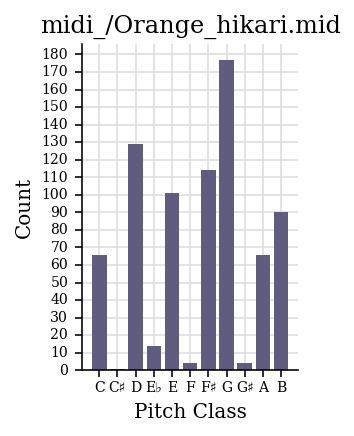

In [0]:
p = graph.plot.HistogramPitchClass(midi, title=file, figureSize=(2,3))
p.id
p.run()

# What Changed?

---

Using a different dataset of midi files there were some differences in how the music was interpreted. Initially, the original code grabbed every track of the midi file and parsed it down. After gaining further analysis into the midi tracks , we noticed that track 0 through track 5 contained what seemed to be the melody and other defining moments in the songs. 

The other tracks in the file contained fillers and events that did not present any mind blowing results for the model. We then limited the range of the tracks and only selected notes and chords from track 0 to 5 while discarding the rest.

The results before making these modifications weren't all that good, it resulted in random rhythms, notes and patterns without any meaningful structure. After the modifications the generated notes and chords had a more musical feeling and overall muscal output.


# Data Preprocessing II

---

The second block of preprocessing code formats the obtained notes into a applicable form for our LSTM. Sequences abled to be grouped together to predict the next note are constructed by one-hot encoding each of the notes, and then creating an array of sequences.

First, an index is assigned to each possible note of 221, as mentioned earlier. Out of that, sequences are constructed by taking each note and encoding it into a numpy array with a '1' in the position of the note given. In this particular block, there is one variable that has a determining sway over the generative output of our model. That variable is sequence_length. The length of a sequence is how our network makes its prediction of the next note or chord. Our network bases the next sequence output on the previous sequence input, a sort of snake-eating-its-own-tail process that helps the model locate patterns and rhythms.

# Before

---

Another block of preprocessing code was modified from its original content to assist the model.

Original:

In [0]:
# data preproccesing code before changes to the code were written 
# # def prep_sequences(notes, n_vocab):
#   sequence_length = 100
#   # collect all of the pitch names in MIDI data
#   pitchnames = sorted(set(item for item in notes))

#   # create a dictionary that maps pitches to integers
#   note_to_int = dict((note, number) for number, note in 
#                       enumerate(pitchnames))

#   network_input = []
#   network_output = []

#   # create input sequences and corresponding outputs
#   for i in range(0, len(notes) - sequence_length, 1):
#     # to predict the next note in the sequence
#     # the network has the previous sequence_le
#     # ngth notes to acclimatize its prediction
#     sequence_in = notes[i:i + sequence_length] 
#     sequence_out = notes[i + sequence_length] 
#     # map pitches of sequence_in to integers
#     network_input.append([note_to_int[char] for char in sequence_in])
#     # map integer of sequence_out to an integer
#     network_output.append(note_to_int[sequence_out])

#   n_patterns = len(network_input)

#   # reshape the input into a format compatible with LSTM layers
#   network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

#   # normalize input
#   network_input = network_input / float(n_vocab)

#   # categorical encoding, or, one-hot encoding the output
#   network_output = np_utils.to_categorical(network_output)
  
# #   return (network_input, network_output)

# After

---
Modified version used to preprocess data for our model:


In [0]:
# assign an index to 
# each possible note
note_dict = dict()
for i, note in enumerate(pitches):
    note_dict[note] = i

# construct sequences 
# by taking each note 
# and encoding it int 
# o a numpy array wit
# h a '1' in the posi
# tion of the note th
# e sequence has
sequence_length = 50
# make a numpy array with the number of train
# ing examples, sequence length, and the leng
# th of the one-hot-encoding
num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

# i is the training example, j 
# is the sequence note for the 
# specific training example
for i in range(0, num_training):
    input_sequence = notes[i: i+sequence_length]
    output_note = notes[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

# What is different?

---

One-hot encoding of the sequences was performed differently. In place of normalizing the input sequence, and then one-hot encoding the output sequence, we chose to one-hot encode botht the input and output sequences. This change allowed us more freedom in expressing our data. Instead of using character training data, the machine is offered numbered data which is important for inputting into an LSTM. This results in our prediction problem becoming easier for the model to solve.

# Model Architecture

---
Our model architecture uses four layer types.



1. LSTM: Long-Short-Term-Memory layer, a RNN layer that takes a sequence as an input, and then returns either a squence or a matrix.
2. Dropout: A regularization technique consisting of setting a fraction of input units to 0 at each update during training to combat overfitting. The parameter applied to this layer determines the fractional amount.
3.Dense: Fully connected neural network layer in which each input node is connected to each output node.
4. Activation: Used to determine the activation function out neural network will use to calculate the output of a node.

For the first LSTM layer, we provide a uniqu parameter *input_shape* to inform the network of the shape of the training data.




# Loss Function

---

Calculations of loss for each iteration of the training use categoical_crossentropy since each output belongs only to a single class, and since we have more than two classes to work on.

# Optimizer

---

Our network is optimized by rmsprop, this usually fits best on RNNs or Recurrent Neural Networks. RNNs are a derivation of LSTMs so using this optimizer reflected the best choice.

In [0]:
RMSprop = optimizers.rmsprop(lr=0.001)

In [0]:
model = Sequential()
model.add(LSTM(16, return_sequences=True, 
               input_shape=(sequence_length, vocab_length)))
model.add(Dropout(0.3))

model.add(LSTM(16))
model.add(Dropout(0.3))

model.add(Dense(vocab_length))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop, 
              metrics = ['accuracy'])

The model architecture didn't have very many modifications. The performed adjustmens was the removal of three layers

**model.add(LSTM(512))**

**model.add(Dense(256))**

**model.add(Dropout(0.3))**

These three layers were inset, one after the other, following the second Dropout layer, and preceding the first Dense activation. Apart from the removal of these layers, both Dropout functionalities were originally 0.3, and, after some training, sized down to 0.2.

In [47]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 16)            24512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 366)               6222      
_________________________________________________________________
activation_4 (Activation)    (None, 366)               0         
Total params: 32,846
Trainable params: 32,846
Non-trainable params: 0
_________________________________________________________________


# Training

---
We perform a train to validate split using *keras.model.fit's validation_split* parameter instantiated with a 0.2 cut, or 80% to 20% data split between train and validate, in that order. Implemented on top of the training and validation, our model saves after every epoch with *tf.keras.callbacks.ModelCheckpoint*, which saves the model checkpoints with the epoch number and the validation loss into our Google Drive account.

The model checkpoints are the weights of the model. These weights can be employed to perform predictions as is, or used as the basis for ongoing training.

The only changes from our original model where this block is concerned have been made the the batch_size parameter, which, originally set to 64, has been resized to 128.


In [0]:
# def train(model, network_input, network_output):
#   filepath = "/content/drive/My Drive/{epoch:02d}-{loss:.4f}.h5"

#   checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0,
#                                save_best_only=True, mode='min')

#   callbacks_list = [checkpoint]

history = model.fit(input_notes, output_notes, batch_size=64, epochs=50, 
                      validation_split=0.2)
  
#   callbacks=callbacks_list

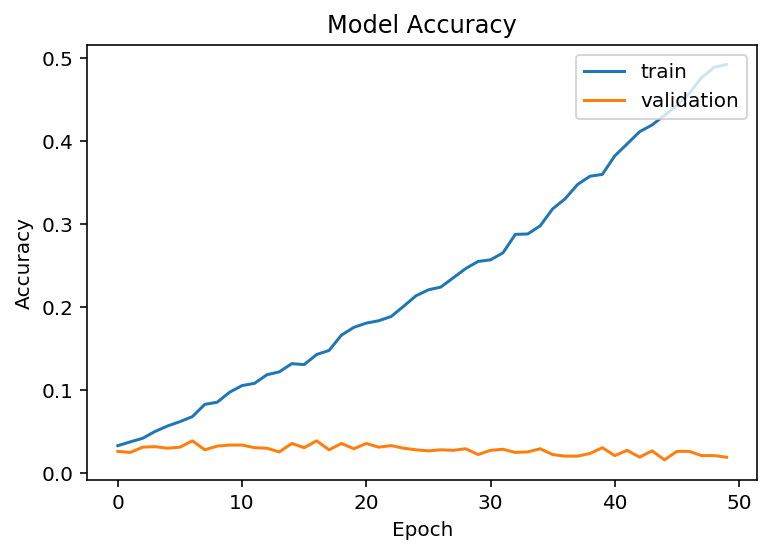

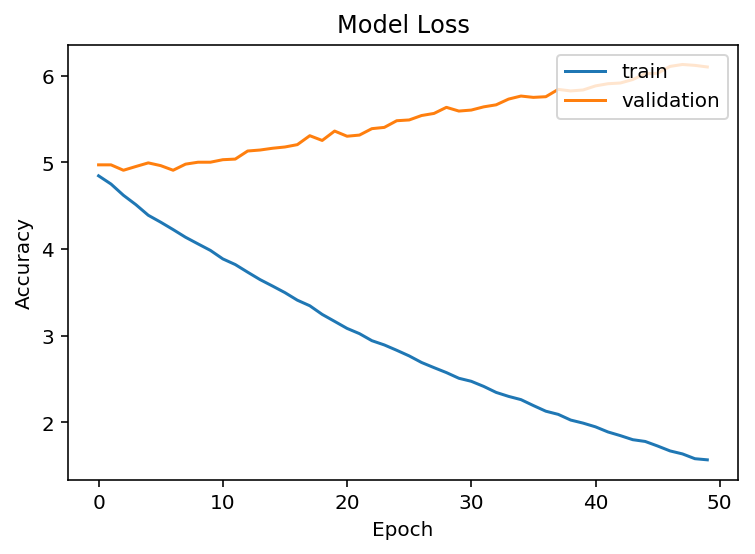

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], 
           loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], 
           loc='upper right')
plt.show()

In [0]:
# Make a dictionary going backwards (with index as key and the note as the value)
backward_dict = dict()
for note in note_dict.keys():
    index = note_dict[note]
    backward_dict[index] = note

# pick a random sequence from the input as a starting point for the prediction
n = np.random.randint(0, len(input_notes)-1)
sequence = input_notes[n]
start_sequence = sequence.reshape(1, sequence_length, vocab_length)
output = []


for i in range(0, 500):
    newNote = model.predict(start_sequence, verbose=0)
    # Get the position with the highest probability
    index = np.argmax(newNote)
    encoded_note = np.zeros((vocab_length))
    encoded_note[index] = 1
    output.append(encoded_note)
    sequence = start_sequence[0][1:]
    start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
    start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)
#     result = newNote
#     print('\r', 'Predicted ', i, " ",result,end='')  

#Now output is populated with notes in their string form
# for element in output:
#     print(element)

In [0]:
finalNotes = [] 
for element in output:
    index = list(element).index(1)
    finalNotes.append(backward_dict[index])
    
offset = 0
output_notes = []
    
for pattern in finalNotes:
    # if pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # if pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack (speed)
    offset += 0.5

midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='/content/drive/My Drive/train_output_1.mid')

'/content/drive/My Drive/train_output_1.mid'

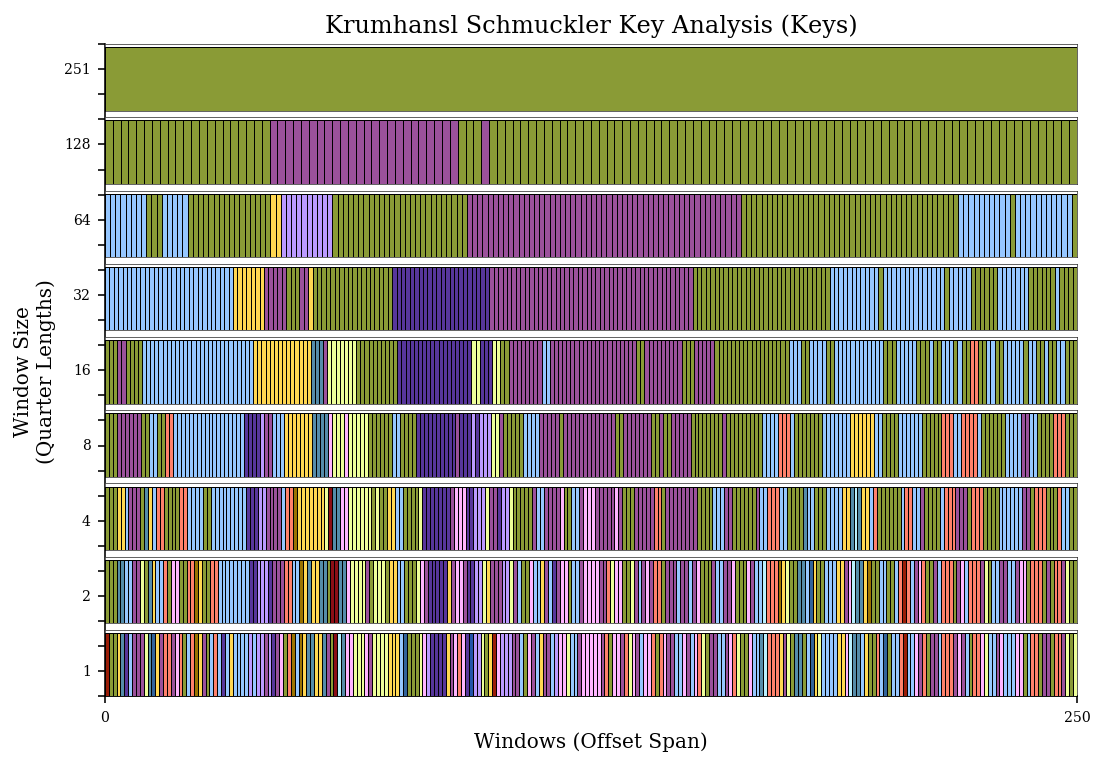

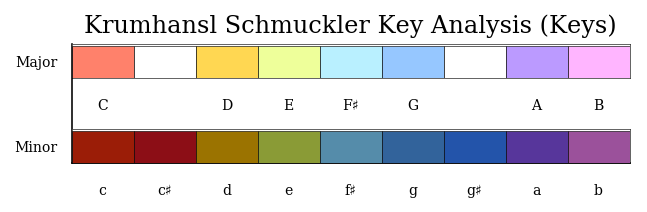

In [0]:
m = graph.plot.WindowedKey(midi_stream)
m.run()

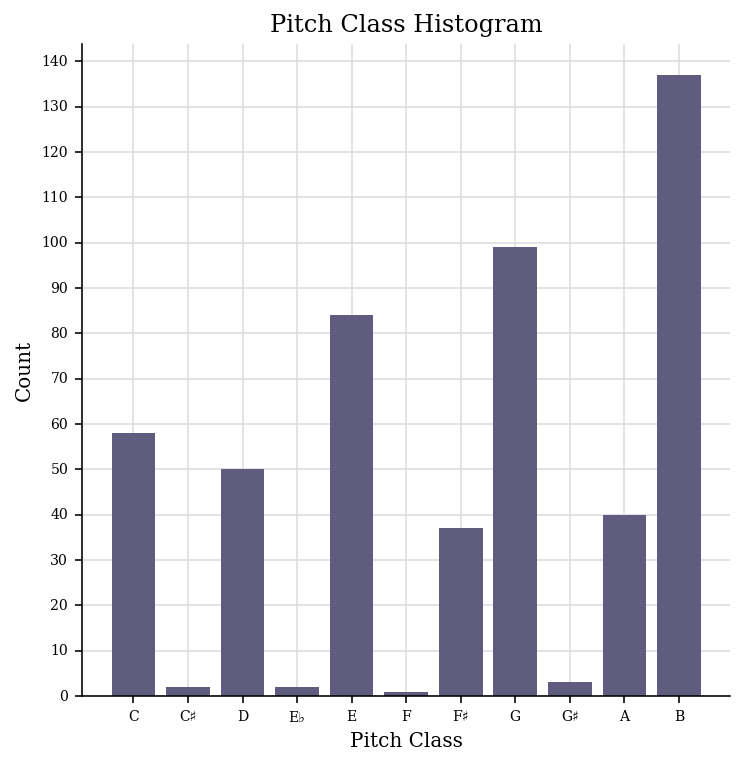

In [0]:
p = graph.plot.HistogramPitchClass(midi_stream)
p.id
p.run()